In [1]:
import numpy as np
import os
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from cp_detection.NeuralODE import GeneralModeDataset, LightningTrainer
from cp_detection.ForceSimulation import ForcedHarmonicOscillator, DMT_Maugis, Null, SimulateGeneralMode

## Define force model as well as QTF model to be used in simulating data

In [2]:
DMT = DMT_Maugis(0.2, 10, 2, 130, 1, 0.3, 0.3)
ode_params = {'Q':12000, 'A0':0.5, 'Om':1., 'k':1000}
FHO = ForcedHarmonicOscillator(**ode_params, force_model = DMT)
#FHO = ForcedHarmonicOscillator(**ode_params, force_model = Null)

## Simulate general mode approach curve data

## Load simulated data and train the model

In [3]:
#savepath = './Data/digital.json'
savepath = './Data/prototype_fake_data.json'
train_dataset = GeneralModeDataset.load(savepath)

In [4]:
import torch
if torch.cuda.is_available:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [5]:
from argparse import Namespace
hparams = Namespace(**{'lr': 0.02, 'batch_size': 20, 'solver': 'rk4', 'hidden_nodes': [10, 10, 10]})
model = LightningTrainer(hparams, train_dataset)

In [6]:
model.TrainModel()

Epoch 1:   0%|          | 0/1 [00:00<?, ?batch/s]

Backward-propagating...

Epoch 2:   0%|          | 0/1 [00:00<00:08,  8.92s/batch, batch_nb=0, gpu=0, loss=0.001, v_nb=14]

Backward-propagating...

KeyboardInterrupt: 

## Load trained model, evaluate results

In [4]:
checkpoint_path = './checkpoints/_ckpt_epoch_31.ckpt'
#checkpoint_path = './hall_of_fame/20200206/_ckpt_epoch_1256.ckpt'
model = LoadModel(checkpoint_path)

In [21]:
d_array = np.linspace(1, 10, 20)
model.cuda()
F_pred = model.predict_force(d_array)
z_array = np.zeros((2, d_array.size))
z_array[1, :] = d_array
F_true = DMT.F(z_array).flatten()

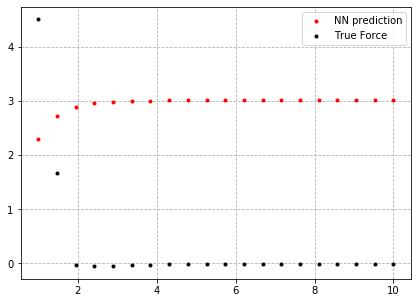

In [22]:
fig, ax = plt.subplots(1, 1, figsize = (7, 5))
ax.plot(d_array, F_pred, '.r', label = 'NN prediction')
ax.plot(d_array, F_true, '.k', label = 'True Force')
ax.legend()
ax.grid(ls = '--')

## Deprecated

In [12]:
from torchviz import make_dot, make_dot_from_trace

# Remember that you can use make_dot, make_dot_from_trace to get a nice visualization of the model flow
# But this does need one epoch of forward propagation, which is extremely costly in the steady state model
# The corresponding script to remember is:
# make_dot(loss, params=dict(nnode.named_parameters()))